In [10]:
import matplotlib.pyplot as plt
import pygame
import numpy as np
import random
import copy
import cma

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [11]:
##### CONSTANTES
N_in = 20*20 + 2 + 2
N1 = 3
N2 = 3
N_out = 2
f = 0.3
rb = 1
rt = 20
m = 1
g = 9.81

ratio_distance = 8
ratio_angle = 100


num_elites = 3
nbre_mouvements = 50
nb_gen = 20
nb_pop = 100
mutation_rate = 2/(nbre_mouvements*2)
v_max = 10

In [12]:
###### FONCTIONS UTILES

def produitvectoriel(vect1,vect2):
    return (vect1[0]*vect2[1] - vect1[1]*vect2[0])

def produitscalaire(vect1,vect2):
    return(vect1[0]*vect2[0] + vect1[1]*vect2[1])

def draw_circle(matrice,i,j,r, colour):
    for x in range(len(matrice)):
        for y in range(len(matrice[x])):
            if abs((x-i)**2 + (y-j)**2) <=r**2:
                matrice[x,y] = colour

def get_line(start, end):
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
    is_steep = abs(dy) > abs(dx)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
    dx = x2 - x1
    dy = y2 - y1
    error = int(dx / 0.5)
    ystep = 1 if y1 < y2 else -1
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
    if swapped:
        points.reverse()
    return points


def draw_segment(matrice, start,end):
    points = get_line(start, end)
    shape = np.shape(matrice)
    for i in points:
        if i[0]<shape[0] and i[1] < shape[1]:
            matrice[i[0],i[1]] = 0.7
        


In [13]:
##### CLASSE JOUEUR
class Joueur:  
    def __init__(self, array_trou,array_balle,obstacles, nbre_mouvements):
        self.is_best = False
        self.fitness = 0
        self.partie = Partie(array_balle,array_trou,obstacles)
        self.liste_mouvements = []
        self.liste_emplacements = [array_balle]
        self.nn = Simple_nn(N_in,N1,N_out)
        for i in range(nbre_mouvements):
            v = random.random()*v_max
            t = random.random()*2*np.pi
            self.liste_mouvements.append([v,t])
            
    def evaluate_fitness(self):
        distance = np.sqrt((self.partie.trou.position[0] - self.partie.balle.position[0])**2 + (self.partie.trou.position[1] - self.partie.balle.position[1])**2 ) 
        if self.partie.reached_goal:
            print("victoire")
            self.fitness = 100000 + 10/(self.partie.nb_coups**2)
        elif (not self.partie.is_dead): 
            self.fitness = 10*self.partie.nb_coups/distance**3 
        else:
            self.fitness = -5*distance*self.partie.nb_coups
        return float(self.fitness)
            
        
    def faire_partie(self):
        self.partie = Partie(array_balle,array_trou,obstacles)
        for i in range(20):
            #print(0)
            if self.partie.is_dead:
                self.evaluate_fitness()
                #print(self.partie.is_dead)
                return
            else:
                #print(1)
                array = self.partie.matrice[int(self.partie.balle.position[0]) -10:int(self.partie.balle.position[0]) +10,int(self.partie.balle.position[1]) -10:int(self.partie.balle.position[1]) +10].flatten()
                #print(2)
                b = np.array([self.partie.balle.position[0],self.partie.balle.position[1],self.partie.trou.position[0],self.partie.trou.position[1]]) 
                #print(3)
                #print(b)
                c = np.concatenate((array, b)).flatten()
                #print(4)
                self.liste_mouvements.append(self.nn.compute(c))
                #print(5)
                a = self.partie.deplacement(self.liste_mouvements[-1])
                #print(6)
                self.liste_emplacements.append(a)
                #print(7)
            #print(self.partie.balle.position)
       # print(self.partie.is_dead)
        self.evaluate_fitness()
        #print(8)
        return
        
        
    
                

In [14]:
###### CLASSE NEURAL NETWORK
class Simple_nn:
    def __init__(self, N_in, N1,N_out):
        self.fitness = 0
        self.l1 = np.random.random((N_in,N1))
        self.l2 = np.random.random((N1,N2))
        self.out = np.random.random((N2,N_out))
    
    def compute(self,inputs):
        x = np.dot(self.l1,np.reshape(inputs,(N_in,1)))
        x = np.dot(self.l2, x)
        x = np.dot(self.out,x)
        x = x/(N_in*N1)
        return (x.flatten())
    
    def transform(self, genes):
        layers = [self.l1.flatten(),self.l2.flatten(),self.out.flatten()]
        L = 0
        j = 0
        for i in range(len(genes)):
            if j >= len(layers[L]):
                L += 1
                j = 0
            layers[L][j] = genes[i]
            j += 1
        self.l1 = np.reshape(np.asmatrix(layers[0]),(N1,N_in))
        self.l2 = np.reshape(np.asmatrix(layers[1]),(N2,N1))
        self.out = np.reshape(np.asmatrix(layers[2]),(N_out,N2))  

In [15]:
#### CLASSE SEGMENT

class Segment:
    def __init__(self,array1,array2):
        self.depart = array1
        self.arrivee = array2
        
    def cross(self , segment):
        ab = [self.arrivee[0] - self.depart[0] , self.arrivee[1] - self.depart[1]]
        apbp = [segment.arrivee[0] - segment.depart[0] , segment.arrivee[1] - segment.depart[1]]
        abp = [segment.arrivee[0] - self.depart[0], segment.arrivee[1] - self.depart[1]]
        aap = [segment.depart[0] - self.depart[0], segment.depart[1] - self.depart[1] ]
        apb = [self.arrivee[0] - segment.depart[0] , self.arrivee[1] - segment.depart[1]]
        apa = [self.depart[0] - segment.depart[0] , self.depart[1] - segment.depart[1]]
        
        c1 = produitvectoriel(ab,apbp) != 0
        c2 = (produitvectoriel(ab,abp) * produitvectoriel(ab,aap))<=0
        c3 = (produitvectoriel(apbp,apb) * produitvectoriel(apbp,apa))<=0
        return(c1 and c2 and c3)

In [16]:
##### CLASSE TROU

class Trou:
    def __init__(self, array):
        self.position = array.copy()
 

In [17]:
##### CLASSE BALLE

class Balle:
    def __init__(self, array):
        self.position = array.copy()

In [18]:
##### CLASSE PARTIE

class Partie:
    def __init__(self, arrayballe,arraytrou, obstacles):
        self.matrice = np.zeros((800,800),dtype = float)
        self.balle = Balle(arrayballe)
        self.trou = Trou(arraytrou)
        self.obstacles = obstacles
        self.is_dead = False
        self.nb_coups = 1
        self.reached_goal = False 
        self.remplir_matrice()
        
    def is_won(self):
        distance = np.sqrt((self.trou.position[0] - self.balle.position[0])**2 + (self.trou.position[1] - self.balle.position[1])**2 )
       # print(distance)
        if distance < rt :
            self.reached_goal = True
    
    def is_possible_move(self,segment_dep):
        liste_obstacles_cross = []
        for i in self.obstacles: # Pour tous les obstacles
            if i.cross(segment_dep): # Si un segment_dep et i se croisent alors le move n'est pas possible
                    liste_obstacles_cross.append(i)
        if len(liste_obstacles_cross) > 0 :
            liste_distances = []
            liste_inter = []
            for i in liste_obstacles_cross:
                if (segment_dep.depart[0] - segment_dep.arrivee[0] == 0):
                    a_i = (i.depart[1] - i.arrivee[1]) / (i.depart[0] - i.arrivee[0])
                    b_i = i.depart[1] - a_i *i.depart[0]
                    x_inter = segment_dep.depart[0]
                    y_inter = a_i * x_inter + b_i
                    liste_inter.append([x_inter , y_inter])
                    
                    
                elif (i.depart[0] - i.arrivee[0] == 0):
                    a_segment_dep = (segment_dep.depart[1] - segment_dep.arrivee[1]) / (segment_dep.depart[0] - segment_dep.arrivee[0])
                    b_segment_dep = segment_dep.depart[1] - a_segment_dep * segment_dep.depart[0]
                    x_inter = i.depart[0]
                    y_inter = a_segment_dep * x_inter + b_segment_dep
                    liste_inter.append([x_inter , y_inter])
                
                else :
                    a_segment_dep = (segment_dep.depart[1] - segment_dep.arrivee[1]) / (segment_dep.depart[0] - segment_dep.arrivee[0])
                    b_segment_dep = segment_dep.depart[1] - a_segment_dep * segment_dep.depart[0]
                    a_i = (i.depart[1] - i.arrivee[1]) / (i.depart[0] - i.arrivee[0])
                    b_i = i.depart[1] - a_i *i.depart[0]
                    x_inter = (b_i - b_segment_dep) / (a_segment_dep - a_i)
                    y_inter = a_i * x_inter + b_i
                    liste_inter.append([x_inter , y_inter])
                
                liste_distances.append(np.sqrt( (x_inter - self.balle.position[0])**2 + (y_inter - self.balle.position[1])**2))
            self.balle.position[0] = liste_inter[liste_distances.index(min(liste_distances))][0]
            self.balle.position[1] = liste_inter[liste_distances.index(min(liste_distances))][1]
                
            return False
        return True
    
    def remplir_matrice(self):
        self.matrice = np.zeros((800,800))
        #draw_circle(self.matrice, int(self.balle.position[0]),int(self.balle.position[1]),rb,1)
        draw_circle(self.matrice,int(self.trou.position[0]),int(self.trou.position[1]),rt,0.2)
        for i in obstacles:
            draw_segment(self.matrice, i.depart,i.arrivee)
        
    def deplacement(self,vitesse_initiale): # La vitesse sera de la forme [ ||v|| , theta)]
        
        distance =abs(0.5*m/f*vitesse_initiale[0,0]*ratio_distance)
        #print("distance = "+str(distance))
        vitesse_initiale[0,1] = vitesse_initiale[0,1] *ratio_angle
        #print(vitesse_initiale[0,1])
        segment_dep = Segment([self.balle.position[0],self.balle.position[1]],[self.balle.position[0] + np.cos(vitesse_initiale[0,1]) * distance,self.balle.position[1] + np.sin(vitesse_initiale[0,1]) * distance] )
        self.is_won()
        
        if self.reached_goal:
            return (self.balle.position[0],self.balle.position[1])
        if self.is_possible_move(segment_dep):
            self.nb_coups +=1
            self.balle.position[0] += np.cos(vitesse_initiale[0,1]) * distance
            self.balle.position[1] += np.sin(vitesse_initiale[0,1]) * distance  
        else :
            self.is_dead = True
        return (self.balle.position[0],self.balle.position[1])

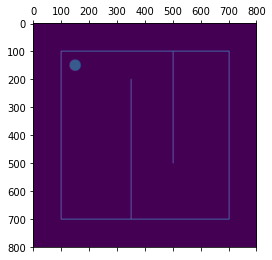

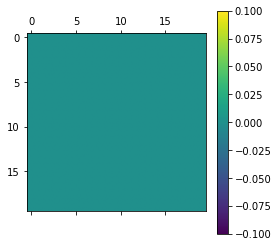

In [ ]:
#DEFINITION DE LA PARTIE
obstacles = []
# On ajoute les murs
obstacles.append(Segment([100,100],[100,700]))
obstacles.append(Segment([100,100],[700,100]))
obstacles.append(Segment([100,700],[700,700]))
obstacles.append(Segment([700,100],[700,700]))
# On ajoute les obstacles
obstacles.append(Segment([100,500],[500,500]))
obstacles.append(Segment([700,350],[200,350]))
#obstacles.append(Segment([0,400],[400,400]))


array_balle = [690,690]
array_trou = [150,150]
partie = Partie(array_balle,array_trou, obstacles)

partie.remplir_matrice()
plt.figure(figsize = (800,800))
im1 = plt.matshow(partie.matrice, interpolation = 'bilinear')
a = partie.matrice[int(partie.balle.position[0]) -10:int(partie.balle.position[0]) +10,int(partie.balle.position[1]) -10:int(partie.balle.position[1]) +10]
im1 = plt.matshow(a, interpolation = 'bilinear')
plt.colorbar(im1)
plt.plot([])
plt.show()

def fitness_function(x):
    joueur = Joueur(array_trou,array_balle,obstacles, nbre_mouvements)
    joueur.nn.transform(x)
    joueur.faire_partie()
    #print(9)
    #draw_circle(joueur.partie.matrice,joueur.partie.balle.position[0],joueur.partie.balle.position[1],4, 1)
    #print(10)
    #plt.matshow(joueur.partie.matrice, interpolation = 'bilinear')
    #plt.show()
    a = joueur.evaluate_fitness()
    print(joueur.partie.is_dead)
    return a
    
    

In [ ]:
x0 = np.random.randn(N_in*N1+N2*N1+ N2*N_out)
es = cma.CMAEvolutionStrategy(x0,0.15)
#help(cma.CMAEvolutionStrategy)
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [-fitness_function(x) for x in solutions])
    es.logger.add()
    es.disp()
        
        
    
        

(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 1227 (seed=1037218, Fri May  8 20:33:45 2020)
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     25 3.812546128015387e+03 1.0e+00 1.49e-01  1e-01  1e-01 0:37.8
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
    2     50 3.805196398328136e+03 1.0e+00 1.48e-01  1e-01  1e-01 1:16.1
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
    3     75 -4.685033767208084e-07 1.0e+00 1.47e-01  1e-01  1e-01 1:53.9
True
True
False
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
    4    100 -2.276647973685245e-06 1.0e+00 1.46e-01  1e-01  1e-01 2:31.9
True
True
True
True
True
True
True

In [ ]:
x0 = np.random.randn(N_in*N1+N2*N1+ N2*N_out)
fitness_function(x0)